In [1]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------------
# 1. Load Dataset
# ---------------------------------------------------------------
df = pd.read_csv("../datasets/waterQuality1.csv")

# Normalize column names
df.columns = df.columns.str.lower().str.strip()

# ---------------------------------------------------------------
# 2. Replace Excel / CSV errors with NaN
# ---------------------------------------------------------------
excel_errors = ["#NUM!", "#DIV/0!", "#REF!", "#VALUE!", "#NAME?", "#NULL!", "#N/A"]
df = df.replace(excel_errors, np.nan)

# Convert all columns to numeric where possible
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ---------------------------------------------------------------
# 3. Standardize label column
# ---------------------------------------------------------------
# Adjust this if your dataset uses a different target name
if "potability" in df.columns:
    df["is_safe"] = df["potability"]
    df = df.drop(columns=["potability"])

# ---------------------------------------------------------------
# 4. Handle missing values
# ---------------------------------------------------------------
df = df.fillna(0)

# ---------------------------------------------------------------
# 5. Split features and target
# ---------------------------------------------------------------
X = df.drop(columns=["is_safe"])
y = df["is_safe"]

print("Dataset shape:", df.shape)
print(df.head(50).to_string())


Dataset shape: (7999, 21)
    aluminium  ammonia  arsenic  barium  cadmium  chloramine  chromium  copper  flouride  bacteria  viruses   lead  nitrates  nitrites  mercury  perchlorate  radium  selenium  silver  uranium  is_safe
0        1.65     9.08    0.040    2.85    0.007        0.35      0.83    0.17      0.05      0.20    0.000  0.054     16.08      1.13    0.007        37.75    6.78      0.08    0.34     0.02      1.0
1        2.32    21.16    0.010    3.31    0.002        5.28      0.68    0.66      0.90      0.65    0.650  0.100      2.01      1.93    0.003        32.26    3.21      0.08    0.27     0.05      1.0
2        1.01    14.02    0.040    0.58    0.008        4.24      0.53    0.02      0.99      0.05    0.003  0.078     14.16      1.11    0.006        50.28    7.07      0.07    0.44     0.01      0.0
3        1.36    11.33    0.040    2.96    0.001        7.23      0.03    1.66      1.08      0.71    0.710  0.016      1.41      1.29    0.004         9.12    1.72      

In [2]:
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------------
# 9. Train/test split
# ---------------------------------------------------------------
# Notes:
# - Splits dataset into training and testing sets
# - X_train, y_train → used to train models
# - X_test, y_test → used to evaluate model performance
# - test_size=0.25 → 25% of data is reserved for testing
# - random_state=42 → ensures reproducible split (same split every run)
# - Formula (conceptually):
#       Training set: 75% of samples
#       Test set: 25% of samples
#       X_train, X_test, y_train, y_test = train_test_split(X, y, ...)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [3]:
# ---------------------------------------------------------------
# 5. Random Forest Classifier
# ---------------------------------------------------------------
# Notes:
# - Random Forest is an ensemble method of decision trees.
# - Each tree is trained on a random bootstrap sample of the training data.
# - At each node, a random subset of features is used to find the best split.
# - Splitting criteria: Gini Impurity or Entropy
#   - Gini Impurity: G = 1 - sum(p_i^2), where p_i = proportion of class i in node
#   - Entropy: H = -sum(p_i * log2(p_i))
# - Predictions: majority vote of all trees
# - Parameters in this code:
#   - n_estimators=300 → number of trees
#   - max_depth=None → trees grow fully until leaves are pure
#   - random_state=42 → ensures reproducible results
# - rf.fit(X_train, y_train) → trains the forest
# - rf.predict(X_test) → predicts labels for test data
# - accuracy_score & classification_report → evaluate performance

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print("===========================================")
print("Random Forest Results")
print("===========================================")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))

Random Forest Results
Accuracy: 0.96

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      1755
         1.0       0.95      0.71      0.81       245

    accuracy                           0.96      2000
   macro avg       0.96      0.85      0.90      2000
weighted avg       0.96      0.96      0.96      2000



In [4]:
# ---------------------------------------------------------------
# 6. Logistic Regression Classifier
# ---------------------------------------------------------------
# Notes:
# - Logistic Regression is a linear model for classification.
# - Uses the sigmoid function to predict probabilities:
#       p(y=1|x) = 1 / (1 + exp(- (w^T * x + b)))
# - Predict class 1 if probability > 0.5, else class 0
# - Pipeline is used to ensure proper preprocessing:
#   1. StandardScaler → scales features to mean=0, std=1
#   2. LogisticRegression → fits model on scaled features
# - Parameters in this code:
#   - max_iter=20000 → allows more iterations for solver to converge
#   - class_weight="balanced" → penalizes majority class in imbalanced datasets
#   - solver="lbfgs" → optimization algorithm
# - logreg_pipeline.fit(X_train, y_train) → trains the pipeline
# - logreg_pipeline.predict(X_test) → predicts labels for test data
# - accuracy_score & classification_report → evaluate performance

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Pipeline: scale → logistic regression
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=20000,          # way more iterations
        class_weight="balanced", # penalize majority class
        solver="lbfgs"
    ))
])

logreg_pipeline.fit(X_train, y_train)

logreg_pred = logreg_pipeline.predict(X_test)

print("===========================================")
print("Logistic Regression Results")
print("===========================================")
print("Accuracy:", accuracy_score(y_test, logreg_pred))
print("\nClassification Report:\n", classification_report(y_test, logreg_pred))


Logistic Regression Results
Accuracy: 0.801

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.81      0.88      1755
         1.0       0.36      0.77      0.49       245

    accuracy                           0.80      2000
   macro avg       0.66      0.79      0.68      2000
weighted avg       0.89      0.80      0.83      2000



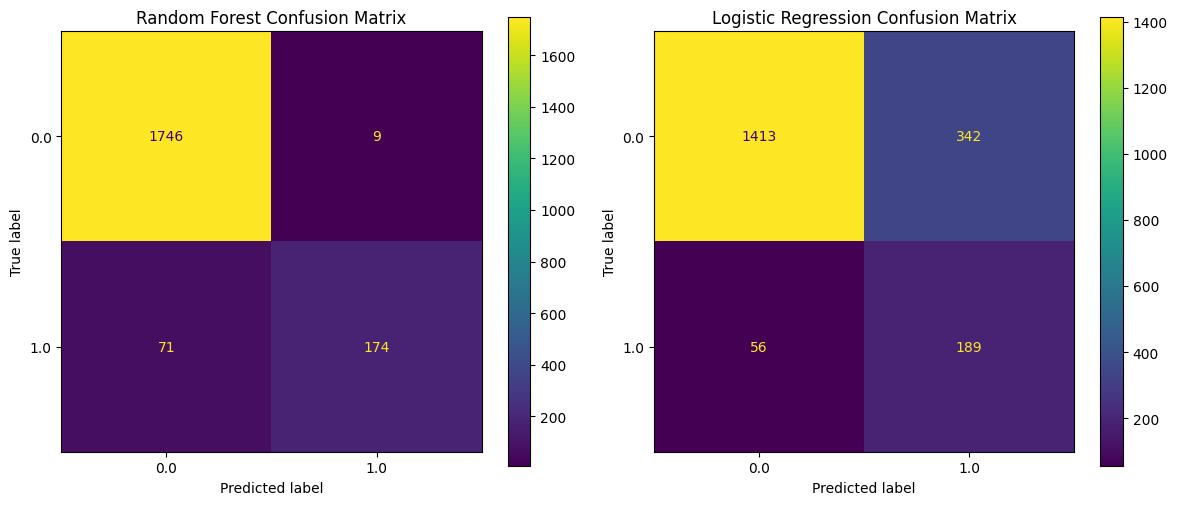

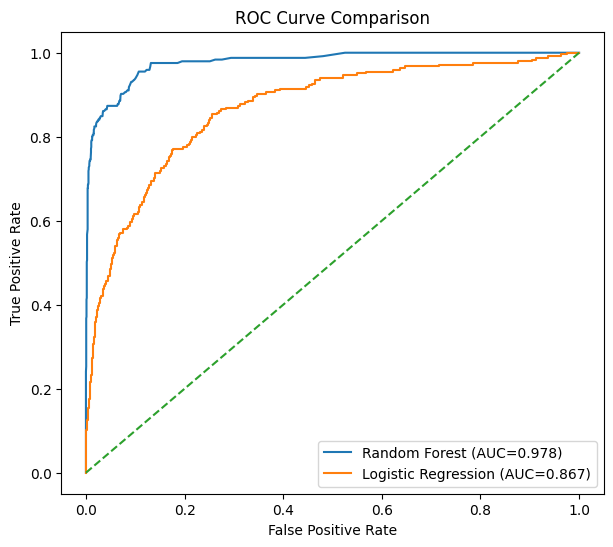

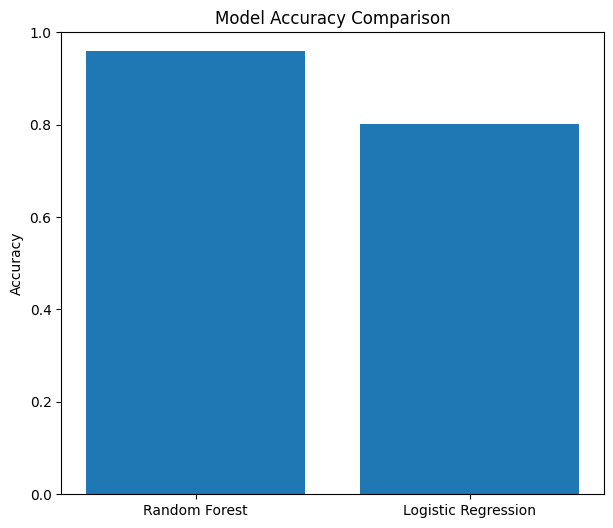

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# ---------------------------------
# CONFUSION MATRICES
# ---------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred, ax=ax[0])
ax[0].set_title("Random Forest Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_test, logreg_pred, ax=ax[1])
ax[1].set_title("Logistic Regression Confusion Matrix")

plt.tight_layout()
plt.show()

# ---------------------------------
# ROC CURVE COMPARISON
# ---------------------------------
rf_probs = rf.predict_proba(X_test)[:, 1]
logreg_probs = logreg_pipeline.predict_proba(X_test)[:, 1]

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
log_fpr, log_tpr, _ = roc_curve(y_test, logreg_probs)

rf_auc = auc(rf_fpr, rf_tpr)
log_auc = auc(log_fpr, log_tpr)

plt.figure(figsize=(7, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC={rf_auc:.3f})")
plt.plot(log_fpr, log_tpr, label=f"Logistic Regression (AUC={log_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# ---------------------------------
# ACCURACY BAR CHART
# ---------------------------------
plt.figure(figsize=(7, 6))
plt.bar(["Random Forest", "Logistic Regression"], 
        [accuracy_score(y_test, rf_pred), accuracy_score(y_test, logreg_pred)])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()
